<h1>Citibike Network Assignment</h1>
<li>The file, 201809-citibike-tripdata.csv, contains citibike trip data from January 2014 (a reasonable sized file!)
<li>The data:<br>
"tripduration","starttime","stoptime","start station id","start station name","start station latitude","start station longitude","end station id","end station name","end station latitude","end station longitude","bikeid","usertype","birth year","gender"
<li>Each record in the data is a trip 
<li>The data is described at https://www.citibikenyc.com/system-data

<h1>STEP 1: Read the data into a dataframe</h1>
<li>Convert station ids to str if necessary

In [3]:
import pandas as pd
import numpy as np
datafile = '2014-01 - Citi Bike trip data.csv'
df = pd.read_csv(datafile)

In [70]:
# df

<h1>STEP 2: Basic cleaning</h1>
<li>Remove data that have any nans in any row (none in this file but others do have nans)
<li>and convert stationids to str 

In [4]:
df = df.dropna(how='any')
df['start station id'] = df['start station id'].astype(str)
df['end station id'] = df['end station id'].astype(str)

In [5]:
df.dtypes

tripduration                 int64
starttime                   object
stoptime                    object
start station id            object
start station name          object
start station latitude     float64
start station longitude    float64
end station id              object
end station name            object
end station latitude       float64
end station longitude      float64
bikeid                       int64
usertype                    object
birth year                  object
gender                       int64
dtype: object

<h1>STEP 3: Write a function that returns a graph given a citibike data frame</h1> 
<li>Your function should return two things:
<ol>
<li>a graph
<li>a dictionary with station ids as the key and station name as the value
</ol>
<li>The graph should contain 
<ol>
<li>nodes (station ids)
<li>edges (station id, station id)
<li>edge data 
<ol>
<li>count: number of trips on the edge
<li>time: average duration - pickup to dropoff - on that edge
</ol>
</ol>
<li><b>Note:</b> the edge (x1,y1) is the same as (y1,x1) even though the start station ids and end station ids are flipped in the dataframe

In [51]:
def get_citibike_graph(dataframe_):
    import networkx as nx
    import datetime
    G = nx.Graph()
    nodes = list()
    count_list = list()
    node_names = dict() 
    edge_count = dict()
    edge_time = dict()
    
    for ids in df['start station id'].unique():
        nodes.append(ids)
        node_names[ids] = df[df['start station id'] == ids]['start station name'].iloc[0]    
    
    start_list = []
    end_list = []
    for i in range(len(df)):
        if df['start station id'][i] > df['end station id'][i]:
            start_list.append(df['end station id'][i])
            end_list.append(df['start station id'][i])
        else:
            start_list.append(df['start station id'][i])
            end_list.append(df['end station id'][i])
            
    import numpy as np
    start_array = np.array(start_list)
    end_array = np.array(end_list)
    
    df['new start station id'] = start_array
    df['new end station id'] = end_array

    df1 = df.groupby(['new start station id','new end station id'])
    df2 = df1['tripduration'].agg(['mean', 'count'])
    df3 = df2.reset_index()

    edge_list = list()
    for i in range(0, len(df3)):
        mini_list = (df3.iloc[i]['new start station id'], df3.iloc[i]['new end station id'], df3.iloc[i]['mean'], df3.iloc[i]['count'])
        mini_list = list(mini_list)
        edge_list.append(mini_list)
    
    import networkx as nxt
    %matplotlib inline
    G =nx.Graph()

    for e in edge_list:
        G.add_edge(e[0],e[1], mean = e[2], count = e[3]) 
        
    nodes = list(node_names.keys())
    
    return (G,node_names)



In [16]:
import networkx as nx

<h1>STEP 4: Create the following graphs using the function above</h1>
<li>G: A graph of all the data in the dataframe
<li>m_G: A graph containing only data from male riders
<li>f_G: A graph containing only data from female riders
<li>Note: for m_G and f_G you will need to extract data from the dataframe

In [52]:
G,nodes = get_citibike_graph(df)

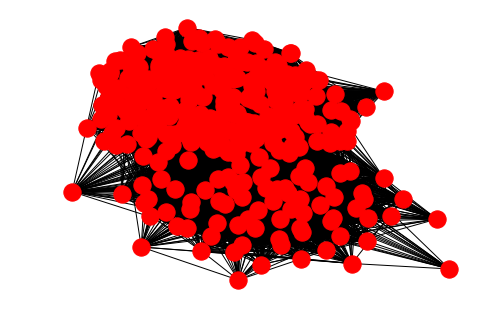

In [53]:
nx.draw(G)

In [70]:
df_m = df[df['gender'] == 1]

In [71]:
m_G,m_nodes= get_citibike_graph(df_m)

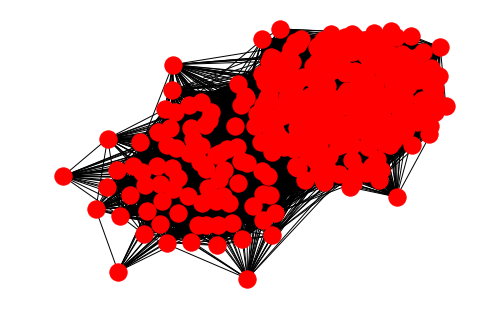

In [72]:
nx.draw(m_G)

In [73]:
df_f = df[df['gender'] == 0]

In [74]:
f_G,f_nodes= get_citibike_graph(df_f)

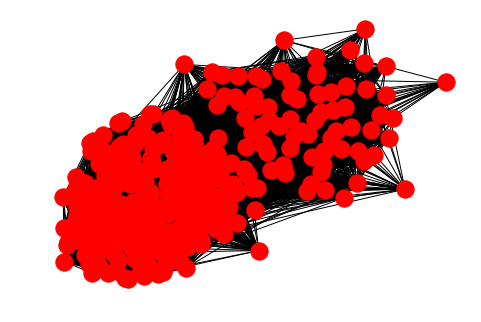

In [75]:
nx.draw(f_G)

<h1>STEP 5: Answer the following questions for each of the graphs</h1>
<ol>
<li>Which station (name) is the best connected (max degree)?
<li>Travel between which pair of stations is the longest in terms of average duration between bike pickups and dropoffs. Report both the two stations as well as the time in minutes
<li>Which edge is associated with the most number of trips?
<li>Which station is the most central?
<li>Which node is a bottleneck node?

Which station (name) has the greatest number of connections (max degree)?

In [76]:
print(type(G))

<class 'networkx.classes.graph.Graph'>


In [78]:
d = list(f_G.degree())
d.sort(key = lambda x: (-x[1]))
maxd = d[1][1]
print ("Busiest female station " + f_nodes[d[0][0]])

d = list(m_G.degree())
d.sort(key = lambda x: (-x[1]))
maxd = d[1][1]
print ("Busiest male station " + m_nodes[d[0][0]])

d = list(G.degree())
d.sort(key = lambda x: (-x[1]))
maxd = d[1][1]
print ("Busiest station " + nodes[d[0][0]])

Busiest female station Lawrence St & Willoughby St
Busiest male station Lawrence St & Willoughby St
Busiest station Lawrence St & Willoughby St


In [65]:
# d=nx.degree(G)
# l=list(d)
# max(l,key=lambda x: x[1])

('323', 299)

Travel between which pair of stations is the longest in terms of average duration between bike pickups and dropoffs

In [79]:
longest = 0
m_node1 = ''
m_node2 = ''
for edge in m_G.edges():
    distance = m_G.get_edge_data(*edge)['mean']
    if longest < distance:
        longest = distance
        m_node1 = edge[0]
        m_node2 = edge[1]
print("Longest average distance males:  " + m_nodes[m_node1] + "  to  " + m_nodes[m_node2] + " . Minutes:  " + str(int(longest/60)))

longest = 0
f_node1 = ''
f_node2 = ''
for edge in f_G.edges():
    distance = f_G.get_edge_data(*edge)['mean']
    if longest < distance:
        longest = distance
        f_node1 = edge[0]
        f_node2 = edge[1]
print("Longest average distance females:  " + f_nodes[f_node1] + "  to  " + f_nodes[f_node2] + " . Minutes:  " + str(int(longest/60)))

longest = 0
node1 = ''
node2 = ''
for edge in G.edges():
    distance = G.get_edge_data(*edge)['mean']
    if longest < distance:
        longest = distance
        node1 = edge[0]
        node2 = edge[1]
print("Longest average distance all:  " + nodes[node1] + "  to  " + nodes[node2] + " . Minutes:  " + str(int(longest/60)))
print((m_node1, m_node2, {'trips': m_G.get_edge_data(*(m_node1, m_node2))['count'], 'mean': m_G.get_edge_data(*(m_node1, m_node2))['mean']}))
print((f_node1, f_node2, {'trips': f_G.get_edge_data(*(f_node1, f_node2))['count'], 'mean': f_G.get_edge_data(*(f_node1, f_node2))['mean']}))
print((node1, node2, {'trips': G.get_edge_data(*(node1, node2))['count'], 'mean': G.get_edge_data(*(node1, node2))['mean']}))

Longest average distance males:  Flushing Ave & Carlton Ave  to  S Portland Ave & Hanson Pl . Minutes:  9093
Longest average distance females:  Flushing Ave & Carlton Ave  to  S Portland Ave & Hanson Pl . Minutes:  9093
Longest average distance all:  Flushing Ave & Carlton Ave  to  S Portland Ave & Hanson Pl . Minutes:  9093
('242', '353', {'trips': 1, 'mean': 545583.0})
('242', '353', {'trips': 1, 'mean': 545583.0})
('242', '353', {'trips': 1, 'mean': 545583.0})


Which edge is associated with the most number of trips?

In [81]:
most = 0
m_node1 = ''
m_node2 = ''
for edge in m_G.edges():
    trips = m_G.get_edge_data(*edge)['count']
    if most < trips:
        most = trips
        m_node1 = edge[0]
        m_node2 = edge[1]
print("most trip route males:  " + m_nodes[m_node1] + "  to  " + m_nodes[m_node2] + " . Minutes:  " + str(int(m_G.get_edge_data(*(m_node1, m_node2))['mean']/60)))

most = 0
f_node1 = ''
f_node2 = ''
for edge in f_G.edges():
    trips = f_G.get_edge_data(*edge)['count']
    if most < trips:
        most = trips
        f_node1 = edge[0]
        f_node2 = edge[1]
print("most trip route females:  " + f_nodes[f_node1] + "  to  " + f_nodes[f_node2] + " . Minutes:  " + str(int(f_G.get_edge_data(*(f_node1, f_node2))['mean']/60)))

most = 0
node1 = ''
node2 = ''
for edge in G.edges():
    trips = G.get_edge_data(*edge)['count']
    if most < trips:
        most = trips
        node1 = edge[0]
        node2 = edge[1]
print("most trip route all:  " + nodes[node1] + "  to  " + nodes[node2] + " . Minutes:  " + str(int(G.get_edge_data(*(node1, node2))['mean']/60)))

most trip route males:  E 43 St & Vanderbilt Ave  to  W 41 St & 8 Ave . Minutes:  7
most trip route females:  E 43 St & Vanderbilt Ave  to  W 41 St & 8 Ave . Minutes:  7
most trip route all:  E 43 St & Vanderbilt Ave  to  W 41 St & 8 Ave . Minutes:  7


<h2>Centrality</h2>
One of the concerns that the citibike system has to deal with is ensuring that no station has empty slots (a bike should always be available) and that no station should have no empty slots (you should be able to return a bike). To do this, it needs to monitor the movement of bikes through the system, ideally using a directed graph. Though our graph is not directed, we can look at some network characteristics that will help us answer these questions. Note that the "trips" feature in edge data captures flows.
<li>Which node is a possible bottleneck node in terms of bike flows?
<li>Which node is the "nearest" to all other nodes (irrespective of flows)
<li>Which node is the "nearest" to all other nodes (in terms of distance = time)


In [82]:
from networkx.algorithms import closeness_centrality
from networkx.algorithms import communicability
from collections import OrderedDict

c_c = closeness_centrality(G)
cc = OrderedDict(sorted(
                    c_c.items(),
                    key = lambda x: x[1],
                    reverse = True))

print("Most central in connectivity " + nodes[list(cc)[0]])

c_c = closeness_centrality(G, distance="mean")
cc = OrderedDict(sorted(
                    c_c.items(),
                    key = lambda x: x[1],
                    reverse = True))

print("Most central in connectivity using time as distance " + nodes[list(cc)[0]])
c_c = nx.betweenness_centrality(G, weight = 'count')
cc = OrderedDict(sorted(
                    c_c.items(),
                    key = lambda x: x[1],
                    reverse = True))


print("Bottleneck node " + nodes[list(cc)[0]])
edge = nx.periphery(G)
print('Peripherals are ' + nodes[edge[0]] + " and " + nodes[edge[1]])


Most central in connectivity Lawrence St & Willoughby St
Most central in connectivity using time as distance Fulton St & Rockwell Pl
Bottleneck node Atlantic Ave & Fort Greene Pl
Peripherals are W 54 St & 9 Ave and Carlton Ave & Park Ave
